In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [3]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [4]:
data_dir = 'pizza_not_pizza'

dataset = ImageFolder(root=data_dir, transform=transform)

# Split the dataset into training (80%) and testing (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
class PizzaClassifier(nn.Module):
    def __init__(self):
        super(PizzaClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = PizzaClassifier()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [9]:
train(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 0.7151620185375214
Epoch 2, Loss: 0.595654770731926
Epoch 3, Loss: 0.530046991109848
Epoch 4, Loss: 0.5158610361814499
Epoch 5, Loss: 0.46998388588428497
Epoch 6, Loss: 0.44938355445861816
Epoch 7, Loss: 0.3947958168387413
Epoch 8, Loss: 0.3039738056063652
Epoch 9, Loss: 0.2248377715423703
Epoch 10, Loss: 0.18557799629867078


In [10]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total}%')

In [11]:
test(model, test_loader)


Accuracy: 73.09644670050761%


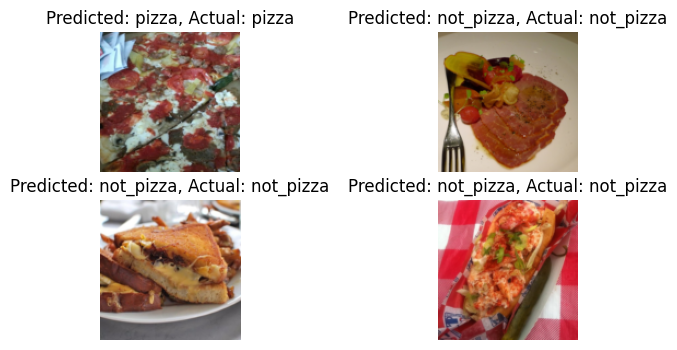

In [16]:
def visualize_predictions(model, test_loader, num_images=4):
    model.eval()
    images_so_far = 0
    n_rows = num_images // 4 if num_images % 4 == 0 else num_images // 4 + 1
    fig = plt.figure(figsize=(8, n_rows * 4))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {dataset.classes[preds[j]]}, Actual: {dataset.classes[labels[j]]}')
                plt.imshow(inputs[j].permute(1, 2, 0))
                
                if images_so_far == num_images:
                    return

visualize_predictions(model, test_loader)